In [1]:
import h5py
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
import sys
import shutil
import glob
import optparse
import os
import json
import cPickle as pkl
import pandas as pd
import numpy as np
import pylab as pl
import scipy.stats as stats
import seaborn as sns
sys.path.append('/n/coxfs01/cechavarria/repos/2p-pipeline/')
from pipeline.python.paradigm import utils as util

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/utils.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in 

In [2]:
class struct: pass

opts = struct()
opts.rootdir = '/n/coxfs01/2p-data'
opts.animalid = 'JC080'
opts.session = '20190619'
opts.acquisition = 'FOV1_zoom4p0x'
opts.traceid = 'traces001'
opts.combined_run = 'scenes_combined'

In [3]:
traceid = '%s_s2p'%(opts.traceid)
#% Set up paths:    
acquisition_dir = os.path.join(opts.rootdir, opts.animalid, opts.session, opts.acquisition)
traceid_dir = os.path.join(acquisition_dir, opts.combined_run,'traces',traceid)

run_dir = traceid_dir.split('/traces')[0]
trace_arrays_dir = os.path.join(traceid_dir,'files')
paradigm_dir = os.path.join(acquisition_dir, opts.combined_run, 'paradigm')

In [4]:
#get file with trial-by-trial responses
responses_dir = os.path.join(acquisition_dir, opts.combined_run,'responses',traceid)
data_array_dir = os.path.join(responses_dir, 'data_arrays')

resp_array_fn = 'trial_response_array.hdf5'
resp_array_filepath = os.path.join(data_array_dir,'files' , resp_array_fn)
resp_grp = h5py.File(resp_array_filepath, 'r')


curr_slice = 'Slice01'#hard,coding for now

#unpack
filter_crit_matrix_trials = np.array(resp_grp['/'.join([curr_slice, 'responses' ,'zscore'])])

resp_grp.close()


In [5]:
filter_crit_matrix_mean = np.squeeze(np.mean(filter_crit_matrix_trials,0))

In [6]:
thresh = 1
filter_matrix = filter_crit_matrix_mean>thresh

In [13]:
filter_matrix.shape

(60, 208)

In [19]:
#load trial info
stimconfig_fn = 'trial_conditions.hdf5'
stimconfig_filepath = os.path.join(paradigm_dir, 'files', stimconfig_fn)
config_grp = h5py.File(stimconfig_filepath, 'r')

ntrials = config_grp.attrs['ntrials']
trial_config = np.array(config_grp['trial_config'])
trial_cond = np.array(config_grp['trial_cond'])
trial_img = np.array(config_grp['trial_img'])

config_grp.close()

In [ ]:
#read trace file file
parsedtraces_filepath = glob.glob(os.path.join(traceid_dir, 'files','parsedtraces*'))[0]
file_grp = h5py.File(parsedtraces_filepath, 'r')


pre_frames = file_grp.attrs['pre_frames']
post_frames = file_grp.attrs['post_frames']
stim_frames = file_grp.attrs['stim_frames']
#to get baseline index with [0:pre_frames]
#to get stim period do [pre_frames:pre_frames+stim_frames+1]

curr_slice = 'Slice01'#hard-code planar data for now
#get raw pixel value arrays
pix_raw_array = np.array(file_grp[curr_slice]['traces']['raw'])
pix_cell_array = np.array(file_grp[curr_slice]['traces']['np_subtracted'])
pix_np_array = np.array(file_grp[curr_slice]['traces']['neuropil'])


file_grp.close()

ROIs:208
Trials:1500
config045
25


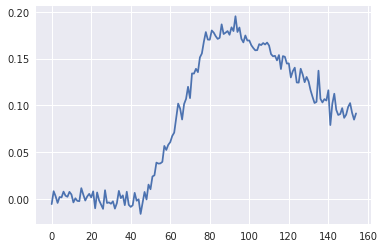

In [47]:
#norm across all trials, per roi then average within config

ntrials,ntpts,nrois = pix_cell_array.shape
nconfigs = len(np.unique(trial_config))
print('ROIs:%i'%(nrois))
print('Trials:%i'%(ntrials))


mean_norm_trace_array = np.empty((ntpts,nconfigs,nrois))

#for ridx in range(nrois):
ridx = 0
roi_df_array = np.empty((ntrials,ntpts))
for tidx in range(ntrials):

    #get trial timecourse
    pix_cell = np.squeeze(pix_cell_array[tidx,:,ridx].squeeze())

    #get baseline
    base_cell = pix_cell[0:pre_frames]
    
    #calculate df
    df_cell = pix_cell - np.mean(base_cell)

    #store in array
    roi_df_array[tidx,:] = df_cell
#normalize traces by roi for all trials
norm_roi_df_array = roi_df_array/np.nanmax(roi_df_array.flatten())
# = np.nanmean(norm_roi_df_array,0)

#for cfg_idx in np.unique(trial_config):
cfg_idx = 45

cfg_key = 'config%03d'%(cfg_idx)
print(cfg_key)
tidx = np.where(trial_config == cfg_idx)[0]
print(len(tidx))

mean_norm_trace_array[:,cfg_idx,ridx] = np.nanmean(norm_roi_df_array[tidx,:],0)

plt.plot(mean_norm_trace_array[:,cfg_idx,ridx])

In [53]:
#for each roi, first average across trials per config, then normalize across configs
#-should result in higher values, also noticed bigger differences in values
ntrials,ntpts,nrois = pix_cell_array.shape
nconfigs = len(np.unique(trial_config))
print('ROIs:%i'%(nrois))
print('Trials:%i'%(ntrials))


mean_norm_trace_array = np.empty((ntpts,nconfigs,nrois))

#for ridx in range(nrois):
ridx = 0
roi_df_array = np.empty((ntrials,ntpts))
for tidx in range(ntrials):

    #get trial timecourse
    pix_cell = np.squeeze(pix_cell_array[tidx,:,ridx].squeeze())

    #get baseline
    base_cell = pix_cell[0:pre_frames]
    
    #calculate df
    df_cell = pix_cell - np.mean(base_cell)

    #store in array
    roi_df_array[tidx,:] = df_cell


mean_df_array = np.empty((nconfigs,ntpts))
for cfg_idx in np.unique(trial_config):
    #cfg_idx = 45

    cfg_key = 'config%03d'%(cfg_idx)
    print(cfg_key)
    tidx = np.where(trial_config == cfg_idx)[0]
    print(len(tidx))

    mean_df_array[int(cfg_idx),:] = np.nanmean(roi_df_array[tidx,:],0)

ROIs:208
Trials:1500
config000
25
config001
25
config002
25
config003
25
config004
25
config005
25
config006
25
config007
25
config008
25
config009
25
config010
25
config011
25
config012
25
config013
25
config014
25
config015
25
config016
25
config017
25
config018
25
config019
25
config020
25
config021
25
config022
25
config023
25
config024
25
config025
25
config026
25
config027
25
config028
25
config029
25
config030
25
config031
25
config032
25
config033
25
config034
25
config035
25
config036
25
config037
25
config038
25
config039
25
config040
25
config041
25
config042
25
config043
25
config044
25
config045
25
config046
25
config047
25
config048
25
config049
25
config050
25
config051
25
config052
25
config053
25
config054
25
config055
25
config056
25
config057
25
config058
25
config059
25


In [54]:
#normalize traces across configs
norm_roi_df_array = mean_df_array/np.nanmax(mean_df_array.flatten())

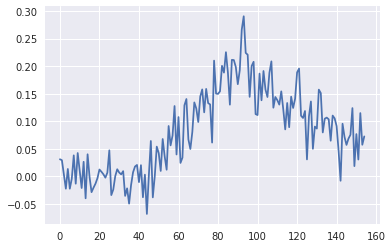

In [63]:
plt.plot(norm_roi_df_array[48,:])

In [49]:
roi_df_array.shape

(1500, 155)

In [ ]:
#----Junk Code below here------

In [ ]:
#open timecourse file to read
data_array_fn = 'processed_config_traces.hdf5'
data_array_filepath = os.path.join(traceid_dir, 'data_arrays', data_array_fn)
data_grp = h5py.File(data_array_filepath, 'r')

frames_tsec = data_grp.attrs['frames_tsec']
nrois = data_grp.attrs['nrois']
print('ROIs:%i'%(nrois))

if 's2p_cell_rois' in data_grp.attrs.keys():
    cell_rois = data_grp.attrs['s2p_cell_rois']
else:
    cell_rois = np.arange(nrois)

curr_slice = 'Slice01'#hard,coding for now

In [ ]:
trace_type = 'df_f'

In [ ]:
data_type = 'np_subtracted'

In [ ]:

for cfg_count,cfg_key in enumerate(data_grp[curr_slice].keys()):
    # cfg_count = 0
    # cfg_key = 'config000'

    #find rois responsive to this condition
    ridxs = np.where(filter_matrix[cfg_count,:])[0]

    if cfg_count == 0:
        filtered_trace_mean = np.zeros((np.array(data_grp['/'.join([curr_slice,cfg_key,trace_type, 'trace_mean',data_type])]).shape[0],len(data_grp[curr_slice].keys())))
        filtered_trace_se = np.zeros((np.array(data_grp['/'.join([curr_slice,cfg_key,trace_type, 'trace_mean',data_type])]).shape[0],len(data_grp[curr_slice].keys())))
    if ridxs.size>0:
        trace_array = np.empty((np.array(data_grp['/'.join([curr_slice,cfg_key,trace_type, 'trace_mean',data_type])]).shape[0],ridxs.size))
        for ridx_count, ridx in enumerate(ridxs):
            #consider only cells ROIS!! <- To Do
            trace_array[:,ridx_count] = np.array(data_grp['/'.join([curr_slice,cfg_key,trace_type, 'trace_mean',data_type])])[:,ridx]
    #take average and store in array
    filtered_trace_mean[:,cfg_count] = np.mean(trace_array,1)
    filtered_trace_se[:,cfg_count] = stats.sem(trace_array,1)

In [ ]:
filtered_trace_mean[:,2]